# Capstone Project
## Machine Learning Engineer Nanodegree

## Definition

### Project Overview

### Problem Statement
The problem we aim at solving is to find an optimal policy to buy and sell some given stock in order to make profits out of difference between buying price and selling price. We will try to find a solution to this problem through a reinforcement learning approach. In particular, we plan to use Q-learning. We will choose a set of relevant features, on the assumption that their combination might have some predictive power.

In a nutshell, we will be satisfied with the solution if the graph of cumulative profits over time has an upward trending slope and the ratio between the sum of all profits and the sum of all losses is at least greater than 2. This will mean that our model makes twice as much money than it loses, thus ensuring both profitability and low volatility.

### Metrics
* Graph of cumulative profits over time: this shows if the amount cumulative profits made by our agent are a positive amount, how smoothly profits are made with respect to the losses and the downside risk of the periods of negative performance

* Profits minus losses: how much the agent has made minus how much the agent has lost

* Average profit or loss per trade

* Standard deviation of profits and losses

* Percentage of winning trades over all trades (n. of winning trades + n. of losing trades)

* Average profit of winning trades

* Average loss of losing trades

* Drawdowns: amount of money lost from any cumulative peak in the profit curve

    * Worst peak-to-valley drawdown

    * Average drawdown

    * Median drawdown

    * 3rd quartile drawdown

* Recovery time from drawdowns: amount of time it takes to our agent to recover the amount of money previously lost

    * Worst peak-to-valley drawdown recovery time

    * Average drawdown recovery time

    * Median drawdown recovery time

    * 3rd quartile drawdown recovery time

* Risk-adjusted profit or loss measures:

    * Average profit or loss per trade divided by standard deviation of profits and losses

    * Average profit or loss per trade divided by standard deviation of losses only

    * Average profit or loss per trade divided by worst peak-to-valley drawdown

    * Sum of money made of winning trades divided by sum of money lost on losing trades

Our ideal agent:

* makes more money than it loses,

* shows a smooth upward trending profits curve,

* makes high average profits,

* makes low average losses,

* makes high percentage of winning trades,

* makes small drawdowns,

* has short recovery time from drawdowns

## Analysis

### Data Exploration

The dataset consists of financial time series of Apple Inc stock (ticker: AAPL) and comes from Quandl’s open source wiki ([https://www.quandl.com/data/WIKI/AAPL-Apple-Inc-AAPL-Prices-Dividends-Splits-and-Trading-Volume](https://www.quandl.com/data/WIKI/AAPL-Apple-Inc-AAPL-Prices-Dividends-Splits-and-Trading-Volume)). Please find a sample below:

In [28]:
import pandas as pd
import numpy as np
from IPython.display import display

data = pd.read_csv('WIKI-AAPL.csv', index_col=0)

display(data.head())
display(data.tail())

,open,high,low,close,volume,ex_dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
2016-09-06,107.90,108.3000,107.51,107.68,24354375.0,0.0,1.0,107.90,108.3000,107.51,107.68,24354375.0
2016-09-02,107.70,108.0000,106.82,107.73,26802450.0,0.0,1.0,107.70,108.0000,106.82,107.73,26802450.0
2016-09-01,106.14,106.8000,105.62,106.73,26701523.0,0.0,1.0,106.14,106.8000,105.62,106.73,26701523.0
2016-08-31,105.66,106.5699,105.64,106.10,29662406.0,0.0,1.0,105.66,106.5699,105.64,106.10,29662406.0
2016-08-30,105.80,106.5000,105.50,106.00,24863945.0,0.0,1.0,105.80,106.5000,105.50,106.00,24863945.0


,open,high,low,close,volume,ex_dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
1980-12-18,26.63,26.75,26.63,26.63,327900.0,0.0,1.0,0.398490,0.400286,0.398490,0.398490,18362400.0
1980-12-17,25.87,26.00,25.87,25.87,385900.0,0.0,1.0,0.387117,0.389063,0.387117,0.387117,21610400.0
1980-12-16,25.37,25.37,25.25,25.25,472000.0,0.0,1.0,0.379635,0.379635,0.377840,0.377840,26432000.0
1980-12-15,27.38,27.38,27.25,27.25,785200.0,0.0,1.0,0.409713,0.409713,0.407768,0.407768,43971200.0
1980-12-12,28.75,28.87,28.75,28.75,2093900.0,0.0,1.0,0.430213,0.432009,0.430213,0.430213,117258400.0


Along with its daily timestamp as row index, each row contains the following inputs:

* Open: price at which the stock was traded when market opened

* High: highest price at which the stock was traded during the day

* Low: lowest price at which the stock was traded during the day

* Close: price at which the stock was traded when market closed

* Volume: number of stocks traded during the day

* Dividends: amount of money paid by Apple to its stockholders per share

* Splits: see note below

* Split/dividend adjusted open: see note below

* Split/dividend adjusted high: see note below

* Split/dividend adjusted low: see note below

* Split/dividend adjusted close: see note below

* Split/dividend adjusted volume: see note below

(write note explaining split/dividend adjusted price)

For an additional intuitive explanation of how this work, please watch the following video from Udacity’s Machine Learning for Trading course: [https://youtu.be/M2res0zhqjo](https://youtu.be/M2res0zhqjo)

The data per se - as it is given - offers little useful information until it has been preprocessed in order to extract relevant information out of the given data. We postpone documenting such preprocessing steps to the Methodology section.

The only useful information contained in the raw data is the adjusted volume. From now on, we will just refer to it as volume instead of adjusted volume in that it is the only data regarding volume that we are interested in.

The reason why we are interested in volume data is that our fundamental assumption is that price changes are driven by supply and demand and the number of stocks traded indicates whether the price changes are due to a handful of players or to a much larger crowd.

For example, let’s imagine a market where there are very few buyers and sellers. Then, the price will be determined by the supply and demand of those few players. On the contrary, if the crowd trading some market is very large, the equilibrium price will be the result of much wider negotiations. Therefore, we tend to assume that large volumes contribute to more reliable buying and selling signals. In any case, the size of the market - i.e. the number of stocks traded - does matter and we will try to use it to predict price movements, together with other human-engineered features.

Here are a few observations regarding the volume statistics:

* There are 9011 data points, one per trading day from 1980-12-12 to 2016-09-06

* The mean volume is about 91 mln and the median volume is about 63 mln

* The standard deviation of the volume is about 88 mln, which looks pretty high

* The skewness is above 3, which looks high too. We can also notice that the mean is much higher than the median. This suggests us that there are some large outliers on the right side of the distribution.

* The kurtosis is above 28, which is a very high reading. This indicates the tails of the distribution are quite fat.

* The minimum volume was around 250k on 1985-09-27, so during the 80s

* The maximum volume was around 1.9bn (!) on 2000-09-29, during the tech bubble

* There are 616 outliers and 191 major outliers. That is respectively 6.8% and 2.1% of the observations, which looks high. Also, given the outlier lower bound is negative, we infer that all outliers are on the right side of the distribution, since it is not possible the number of stocks traded on some given day is below zero. This tells us there were several days of extraordinary activity in the trading of Apple stocks and it is certainly something to keep in mind.

In [25]:
volumes = data['adj_volume']

n_obs = volumes.count()
mean = volumes.mean()
median = volumes.median()
std = volumes.std()
skew = volumes.skew()
kurt = volumes.kurt()
min = volumes.min()
argmin = volumes.argmin()
max = volumes.max()
argmax = volumes.argmax()

q3, q1 = np.percentile(volumes, [75, 25])
iqr = q3 - q1
outlier_lb = q1 - iqr * 1.5
outlier_ub = q3 + iqr * 1.5
major_outlier_lb = q1 - iqr * 3
major_outlier_ub = q3 + iqr * 3
is_outlier = (volumes < outlier_lb) | (volumes > outlier_ub)
is_major_outlier = (volumes < major_outlier_lb) | (volumes > major_outlier_ub)
n_outliers = is_outlier.sum()
n_major_outliers = is_major_outlier.sum()
n_minor_outliers = n_outliers - n_major_outliers

### Exploratory Visualization

As we can see from the box-and-whisker plot below there are many outliers and some of them are completely elsewhere with respect to the rest of the sample.  This confirms the impression we got in the Data Exploration subsection.

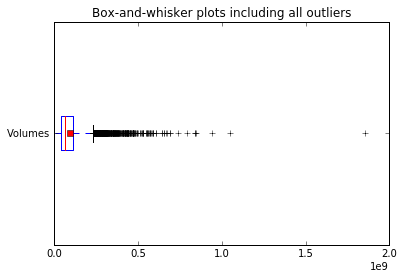

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

# showing all outliers
plt.boxplot(volumes, vert=False, labels=['Volumes'], showmeans=True)
plt.title('Box-and-whisker plots including all outliers')
plt.show()

The plot changes substantially when we remove all major outliers from the picture, i.e. all outliers below Q1 - IQR \* 3 and above Q3 + IQR \* 3.

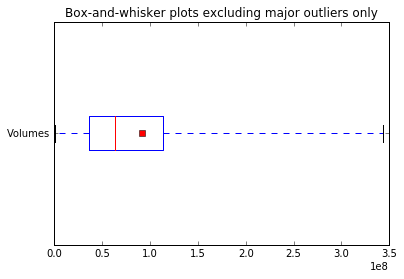

In [27]:
# ignoring major outliers only
plt.boxplot(volumes, vert=False, labels=['Volumes'], showmeans=True,
            showfliers=False, whis=3)
plt.title('Box-and-whisker plots excluding major outliers only')
plt.show()

Eventually, the plot changes even more when we remove all outliers - both major and minor - from the picture, i.e. all outliers below Q1 - IQR \* 1.5 and above Q3 + IQR \* 1.5.

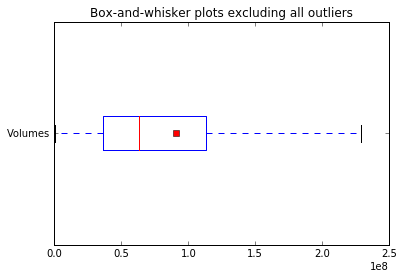

In [29]:
# ignoring all outliers
plt.boxplot(volumes, vert=False, labels=['Volumes'], showmeans=True,
            showfliers=False)
plt.title('Box-and-whisker plots excluding all outliers')
plt.show()

Such visualization gives us a visual intuition of what we observed about outliers in the Data Exploration subsection. The number of outliers is high and this will have to be taken into consideration when building the model.

Then, visualizing the histogram in order to get a visual intuition of the distribution of our volume data confirms what we observed in the Data Exploration subsection. The distribution is clearly positively skewed and it has a very long right tail. Also, it seems the distribution could be approximated by a lognormal distribution.

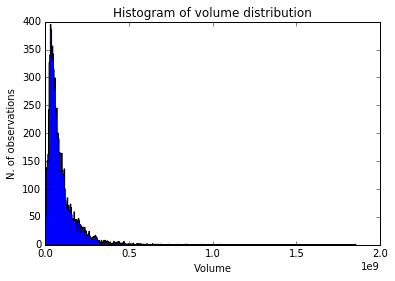

In [31]:
# histogram of volume distribution
plt.hist(volumes, bins=500, histtype='stepfilled')
plt.xlabel('Volume')
plt.ylabel('N. of observations')
plt.title('Histogram of volume distribution')
plt.show()

This is confirmed by the fact that if we do the same plot using the natural logarithm of the data we have a relatively nice bell-shaped curve. We will keep this in mind and see if it is of any help for the rest of the project.

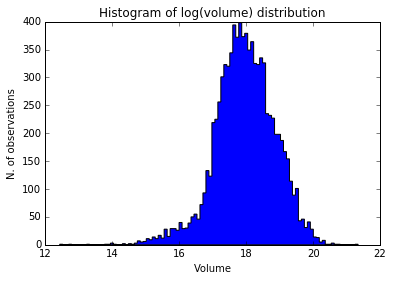

In [33]:
# histogram of log(volume) distribution
plt.hist(np.log(volumes), bins=100, histtype='stepfilled')
plt.xlabel('Volume')
plt.ylabel('N. of observations')
plt.title('Histogram of log(volume) distribution')
plt.show()

### Algorithms and Techniques

Algorithms we will use (temporary list, might add or remove stuff):
* Q-learning
* Logistic regression
* Support vector machines
* Decision tree
* Neural networks (needs more detail or to be omitted)
* Ensemble learning

#### General note on cross-validation for all algorithms
Given the nature of our data, our choice will be to train our models on some given subset of the whole dataset at regular intervals (training set) and test its outcome on some immediately subsequent unseen subset (test set). This is known as roll forward cross validation. Its rationale is that learning some model on the whole dataset is more prone to overfitting than learning some model multiple times on small subsets of the data, thus enabling to run multiple tests with the same data.

The reason why this rolling window or roll forward cross validation is a common practice in the case of financial time series is that we really do not want to look into the future while training some model. Hence, it is of utmost importance that the training sets always precede their respective test set.

#### Q-learning
We will define:
* A state consisting of some set of inputs that I will describe in further detail in the Methodology section
* A set of actions (buy, sell, do nothing)
* A set of rewards for all combinations of starting state, action and arrival state
* A model of transitions learned from the training sets

The reason for using Q-learning is to create an agent which learns the rewards and penalties associated with each state and acts on the test set based on the Q-table it learned from the training set. The metaphor we may use is that of a self-driving car which gets rewarded for driving safely and penalized for crashing, causing damages to people or things, and breaking traffic rules. Accordingly, we will reward our agent when it makes money and penalize it when it loses money.

#### Logistic regression
The reason for using logistic regression is to classify the data points to determine whether the the stock should be bought or sold. We will train the model on the training sets based on the human-engineered features discussed in the Methodology section.

For each data point, we will assign some probability of profiting by buying and some probability of profiting by selling based on whether buying or selling the stock would have made a profit or loss. Eventually, we will label data points in the training set by using a sigmoid function and choosing some minimum threshold in order to classify data points in the ‘buy’ class or in the ‘sell’ class and put all other data points in the ‘do nothing’ class.

#### Support vector machines
The reason for using support vector machines is again to classify the data points to determine whether the the stock should be bought or sold. The purpose is the same as logistic regression but we use a different approach here: we aim at finding a decision boundary that maximizes the margin, i.e. finding a line or hyperplane that is consistent with the data while committing the least to it. The reason why we want to commit the least to our data is that we want to avoid overfitting.

Since it is possible that our data is not linearly separable given our human-engineered features, we will consider using the kernel trick, i.e. we will use some function to add some features by applying some linear transformation to our own features so that our non-linearly separable data becomes linearly separable. This is necessary with SVMs in that this algorithm puts first and foremost correct classification and only after it maximizes the margin. We will also play with the C and gamma parameters in order to find a model that fits the training data well enough but without falling into the trap of overfitting.